In [32]:
import os
from skimage import io
import matplotlib.pyplot as plt
from statistics import mean, stdev
import hashlib

#from tensorflow.keras.applications import ResNet50 deosn't work localy
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [11]:
data_path = "data"
cat_types = os.listdir(data_path)

all_sizes = []      # (path, width, height)

print(f"Total cat types: {len(cat_types)}\n")

for cat in cat_types:
    folder = os.path.join(data_path, cat)
    images = os.listdir(folder)
    print(f"{cat}: {len(images)} images")

    for img_name in images:
        img_path = os.path.join(folder, img_name)
        try:
            img = io.imread(img_path)
            h, w = img.shape[:2]
            all_sizes.append((img_path, w, h))
        except:
            continue

# Compute stats
widths = [w for _, w, _ in all_sizes]
heights = [h for _, _, h in all_sizes]

mean_w, std_w = mean(widths), stdev(widths)
mean_h, std_h = mean(heights), stdev(heights)

print(f"Average size: {int(mean_w)} x {int(mean_h)}")
print(f"Standard deviation: width={int(std_w)}, height={int(std_h)}\n")

# Find outliers
outliers = []
for path, w, h in all_sizes:
    if abs(w - mean_w) > 2 * std_w or abs(h - mean_h) > 2 * std_h:
        outliers.append((path, w, h))

# Print outliers
print(f"\nFound {len(outliers)} outlier images (beyond 2 std dev):\n")
for path, w, h in outliers:
    print(f"{path} --> size: {w} x {h}")


Total cat types: 7

african-wildcat: 91 images
blackfoot-cat: 79 images
chinese-mountain-cat: 43 images
domestic-cat: 64 images
european-wildcat: 85 images
jungle-cat: 86 images
sand-cat: 73 images
Average size: 406 x 310
Standard deviation: width=438, height=323


Found 30 outlier images (beyond 2 std dev):

data\chinese-mountain-cat\ch (11).jpg --> size: 1500 x 1038
data\chinese-mountain-cat\ch (14).jpg --> size: 4000 x 3000
data\chinese-mountain-cat\ch (19).jpg --> size: 4000 x 3000
data\chinese-mountain-cat\ch (2).jpg --> size: 2048 x 1365
data\chinese-mountain-cat\ch (27).jpg --> size: 1644 x 2598
data\chinese-mountain-cat\ch (38).jpg --> size: 1500 x 1048
data\chinese-mountain-cat\ch (7).jpg --> size: 4045 x 2697
data\european-wildcat\eu (1).jpg --> size: 1832 x 1374
data\european-wildcat\eu (10).jpg --> size: 2000 x 1333
data\european-wildcat\eu (11).jpg --> size: 1200 x 1602
data\european-wildcat\eu (15).jpg --> size: 1300 x 866
data\european-wildcat\eu (16).jpg --> size: 1600 

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [13]:

def get_file_hash(path):
    with open(path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()

data_path = "data"
seen_hashes = {}
duplicates = []

for cat in os.listdir(data_path):
    folder = os.path.join(data_path, cat)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            file_hash = get_file_hash(file_path)
            if file_hash in seen_hashes:
                duplicates.append((file_path, seen_hashes[file_hash]))
            else:
                seen_hashes[file_hash] = file_path
        except:
            continue

#optional
'''
for dup_path, _ in duplicates:
    os.remove(dup_path)
'''
print(f"Found {len(duplicates)} exact duplicate files:\n")
for dup_path, orig_path in duplicates:
    print(f"DUPLICATE: {dup_path}\nORIGINAL:  {orig_path}\n")

Found 15 exact duplicate files:

DUPLICATE: data\chinese-mountain-cat\ch (20).jpg
ORIGINAL:  data\chinese-mountain-cat\ch (10).jpg

DUPLICATE: data\european-wildcat\eu (3).jpg
ORIGINAL:  data\european-wildcat\eu (26).jpg

DUPLICATE: data\european-wildcat\eu (5).jpg
ORIGINAL:  data\european-wildcat\eu (27).jpg

DUPLICATE: data\european-wildcat\eu (62).jpg
ORIGINAL:  data\european-wildcat\eu (13).jpg

DUPLICATE: data\european-wildcat\eu (64).jpg
ORIGINAL:  data\european-wildcat\eu (15).jpg

DUPLICATE: data\european-wildcat\eu (69).jpg
ORIGINAL:  data\european-wildcat\eu (17).jpg

DUPLICATE: data\european-wildcat\eu (7).jpg
ORIGINAL:  data\european-wildcat\eu (32).jpg

DUPLICATE: data\european-wildcat\eu (73).jpg
ORIGINAL:  data\european-wildcat\eu (18).jpg

DUPLICATE: data\european-wildcat\eu (74).jpg
ORIGINAL:  data\european-wildcat\eu (50).jpg

DUPLICATE: data\european-wildcat\eu (75).jpg
ORIGINAL:  data\european-wildcat\eu (53).jpg

DUPLICATE: data\european-wildcat\eu (77).jpg
ORIGINA

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [23]:
model = models.resnet50(pretrained=True)

# Count total layers (you can consider each module with parameters as a "layer")
total_layers = sum(1 for _ in model.modules())

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Total layers: {total_layers}")
print(f"Total parameters: {total_params}")

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Owner/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:20<00:00, 4.97MB/s]


Total layers: 151
Total parameters: 25557032


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [26]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

dataset = datasets.ImageFolder(root='data', transform=preprocess)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    print(images.shape)  # Should be [batch_size, 3, 224, 224]
    print(labels)        # Labels as integers
    break

torch.Size([32, 3, 224, 224])
tensor([1, 0, 5, 3, 3, 3, 0, 5, 4, 6, 6, 0, 3, 4, 6, 0, 1, 0, 1, 6, 5, 6, 6, 0,
        3, 5, 1, 1, 1, 1, 2, 0])


### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [27]:
preprocessed_dir = 'preprocessed_data'
os.makedirs(preprocessed_dir, exist_ok=True)

for idx, (img_tensor, label) in enumerate(dataset):
    # Save tensor as a file (.pt format)
    torch.save(img_tensor, os.path.join(preprocessed_dir, f'image_{idx}.pt'))


### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

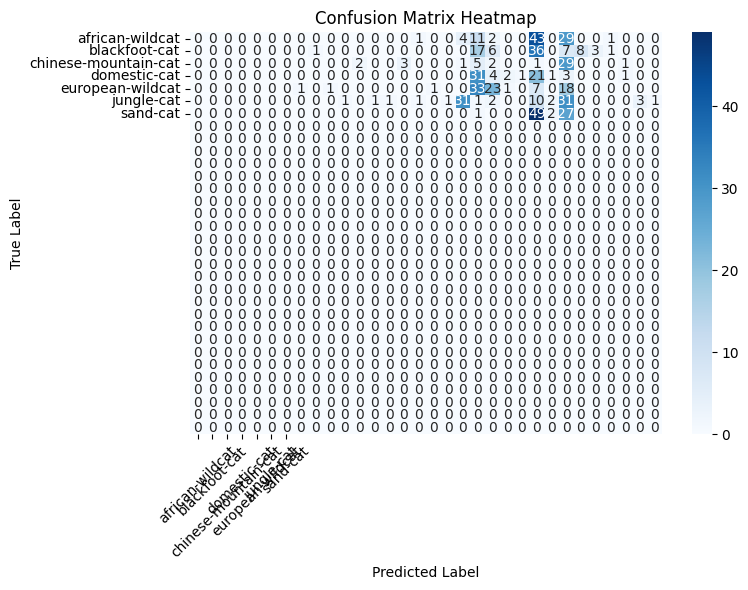

In [33]:
#fail!!!
cm = confusion_matrix(all_labels, all_preds)


class_names = dataset.classes  

plt.figure(figsize=(8, 6))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [34]:
grayscale_preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale but keep 3 channels
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Keep same normalization even if grayscale
        std=[0.229, 0.224, 0.225]
    )
])

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.